# Generate Forecast: Household Consumption Nowcast

## Objectives of Notebook

This notebook aims to:

* Perform forecast using pre-trained model.
* Combine forecast result into one dataframe.

## Import Libraries

In [2]:
%autosave 60
%load_ext autoreload
%autoreload 2

Autosaving every 60 seconds


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
import logging
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()

# Libraries Settings
warnings.filterwarnings('ignore')
logging.disable(logging.CRITICAL)

## Import Customised Functions from Source Code

In [4]:
# Import Functions for Data Preprocessing
from src.preprocess import pearson_corr_rows

# Import Functions for Plotting
from src.plot import  plot_actual_pred

# Import Functions for Utilities
from src.utils import  month_diff_ts

# Import Functions for train & predict
from src.train import pred_ml_model, out_pred_ml_df

## Import Preprocessed Data

* Data that have been preprocessed on previous notebook.

In [5]:
# Load previous DataFrame from previous notebook
%store -r household_consumption
%store -r google_trends
%store -r electronic_transaction_nom
%store -r household_consumption_breakdown

### Convert DataFrame to TimeSeries format

In [6]:
# Convert household_consumption DataFrames into TimeSeries
household_consumption_ts = TimeSeries.from_dataframe(household_consumption, value_cols='household_consumption', fill_missing_dates=True, freq=None)

# Convert electronic_transaction_nom DataFrames into TimeSeries
electronic_transaction_nom_ts = TimeSeries.from_dataframe(electronic_transaction_nom, value_cols='electronic_transac_nom', fill_missing_dates=True, freq=None)

# Convert google_trends DataFrames into TimeSeries
google_trends_ts = TimeSeries.from_dataframe(google_trends, value_cols='google_trends', fill_missing_dates=True, freq=None)


### Instantiate Covariates

Text(0.5, 1.0, 'Combined Covariates')

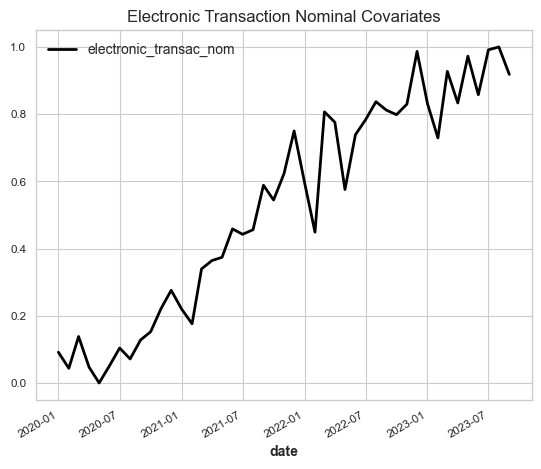

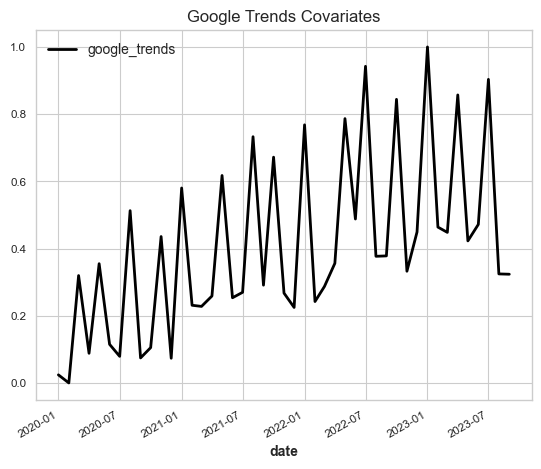

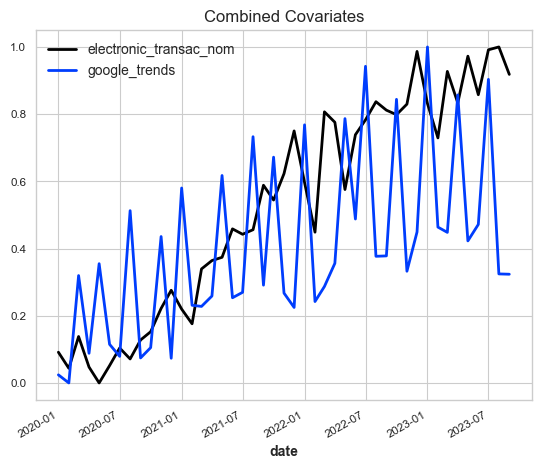

In [7]:
# Stack electronic_transaction_nom and googleTrend to create combined covariate
combined = electronic_transaction_nom_ts.stack(google_trends_ts)

#  Scale household_consumption, electronic_transaction_nom, google_trends, & combinated covariate for plotting
electronic_transaction_nom_scaled_scaled = scaler.fit_transform(electronic_transaction_nom_ts)
google_trends_scaled = scaler.fit_transform(google_trends_ts)
combined_scaled = electronic_transaction_nom_scaled_scaled.stack(google_trends_scaled)

# Plot the covariates
plt.figure()
electronic_transaction_nom_scaled_scaled.plot()
plt.title("Electronic Transaction Nominal Covariates")

plt.figure()
google_trends_scaled.plot()
plt.title("Google Trends Covariates")

plt.figure()
combined_scaled.plot()
plt.title("Combined Covariates")

In [8]:
# Get the difference in len between household_consumption and combined covariate to get nowcast horizon
google_trends_diff_len = month_diff_ts(household_consumption_ts, google_trends_scaled)
electronic_transaction_nom_diff_len = month_diff_ts(household_consumption_ts, electronic_transaction_nom_scaled_scaled)
combined_diff_len = month_diff_ts(household_consumption_ts, combined_scaled)

In [9]:
model_path = r'C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\'

### Prophet

#### Household consumption nowcast using google trends & Prophet model 

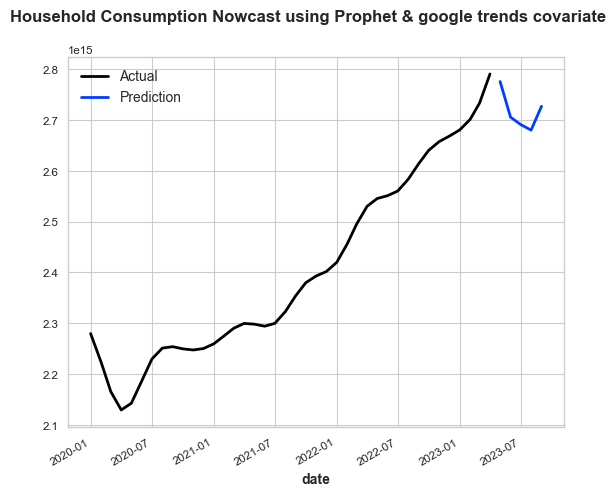

In [10]:
# Import pre-trained prophet model with google trend covariate from a pickle file
household_consumption_prophet_google_trends = pickle.load(open(model_path + r'household_consumption_prophet_google_trends.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_google_trends_prophet = pred_ml_model(
                                model = household_consumption_prophet_google_trends, 
                                len = google_trends_diff_len, 
                                train = household_consumption_ts, 
                                cov = google_trends_ts)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_google_trends_prophet, 'Household Consumption Nowcast using Prophet & google trends covariate')

In [11]:
# Create a DataFrame output using Prophet model and google trends covariate with metric score evaluation
nowcast_google_trends_prophet = out_pred_ml_df(
                                        model=household_consumption_prophet_google_trends,
                                        len = google_trends_diff_len, 
                                        train = household_consumption_ts, 
                                        cov = google_trends_ts,
                                        type_name = 'Google Trends',
                                        model_name = 'Prophet',
                                        start_val=0.6
)
# Show nowcast_google_trends_prophet DataFrame
nowcast_google_trends_prophet

  0%|          | 0/17 [00:00<?, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Google Trends,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Google Trends,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Google Trends,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Google Trends,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Google Trends,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Google Trends,Prophet,2.775124e+15,0.02,7.795844e+13,6.204314e+13,4.2,0.0906,0.0343
58,2023-06-01,Google Trends,Prophet,2.705112e+15,0.02,7.795844e+13,6.204314e+13,4.2,0.1063,-0.0252
59,2023-07-01,Google Trends,Prophet,2.690655e+15,0.02,7.795844e+13,6.204314e+13,4.2,0.1369,-0.0053
60,2023-08-01,Google Trends,Prophet,2.679658e+15,0.02,7.795844e+13,6.204314e+13,4.2,-0.0003,-0.0041


#### Household Consumption Nowcast using electronic transaction nominal & Prophet model

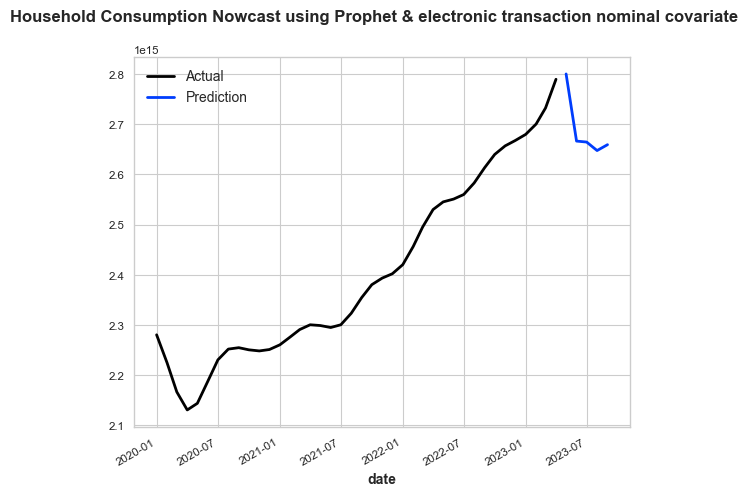

In [12]:
# Import pre-trained prophet model with electronic transaction nominal covariate from a pickle file
household_consumption_prophet_electronic_transaction_nom = pickle.load(open(model_path + r'household_consumption_prophet_electronic_transaction_nom.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_electronic_transaction_nom_prophet = pred_ml_model(
                                            model = household_consumption_prophet_electronic_transaction_nom, 
                                            len = electronic_transaction_nom_diff_len, 
                                            train = household_consumption_ts, 
                                            cov = electronic_transaction_nom_ts)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_electronic_transaction_nom_prophet, 'Household Consumption Nowcast using Prophet & electronic transaction nominal covariate')

In [13]:
# Create a DataFrame output using Prophet model and electronic transaction nominal covariate with metric score evaluation
nowcast_electronic_transaction_nom_prophet = out_pred_ml_df(
                                                model = household_consumption_prophet_electronic_transaction_nom,
                                                len = electronic_transaction_nom_diff_len, 
                                                train = household_consumption_ts, 
                                                cov = electronic_transaction_nom_ts,
                                                type_name = 'Electronic Transaction Nom',
                                                model_name = 'Prophet',
                                                start_val=0.6
)

# Show nowcast_electronic_transaction_nom_prophet DataFrame
nowcast_electronic_transaction_nom_prophet

  0%|          | 0/17 [00:00<?, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Electronic Transaction Nom,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Electronic Transaction Nom,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Electronic Transaction Nom,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Electronic Transaction Nom,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Electronic Transaction Nom,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Electronic Transaction Nom,Prophet,2.800643e+15,0.03,1.473614e+14,8.714532e+13,7.0,0.1536,0.0474
58,2023-06-01,Electronic Transaction Nom,Prophet,2.666633e+15,0.03,1.473614e+14,8.714532e+13,7.0,0.0588,-0.0478
59,2023-07-01,Electronic Transaction Nom,Prophet,2.664712e+15,0.03,1.473614e+14,8.714532e+13,7.0,0.0175,-0.0007
60,2023-08-01,Electronic Transaction Nom,Prophet,2.647738e+15,0.03,1.473614e+14,8.714532e+13,7.0,0.0015,-0.0064


#### Household Consumption Nowcast using combined covariates & Prophet model

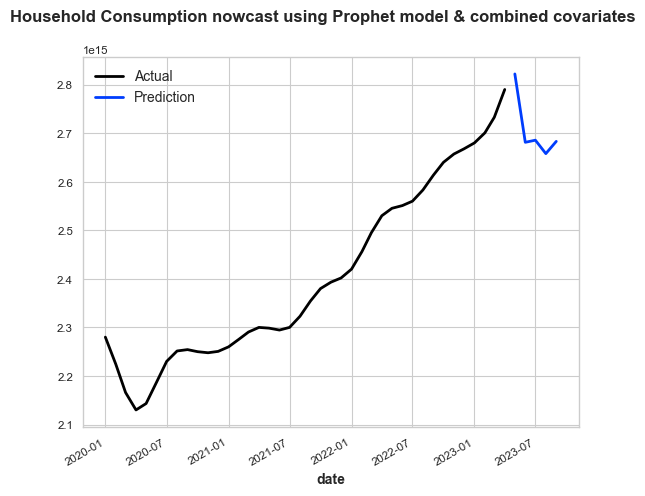

In [14]:
# Import pre-trained prophet model with combined covariate from a pickle file
household_consumption_prophet_combined = pickle.load(open(model_path + r'household_consumption_prophet_combined.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_combined_prophet = pred_ml_model(
                            model = household_consumption_prophet_combined, 
                            len = combined_diff_len, 
                            train = household_consumption_ts, 
                            cov = combined)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_combined_prophet, 'Household Consumption nowcast using Prophet model & combined covariates')

In [15]:
# Create a DataFrame output using Prophet model and combined covariate with metric score evaluation
nowcast_combined_prophet = out_pred_ml_df(
                                model = household_consumption_prophet_electronic_transaction_nom,
                                len = electronic_transaction_nom_diff_len, 
                                train = household_consumption_ts, 
                                cov = combined,
                                type_name = 'Combined',
                                model_name = 'Prophet',
                                start_val=0.6
)

# Show nowcast_combined_prophet DataFrame
nowcast_combined_prophet

  0%|          | 0/17 [00:00<?, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Combined,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Combined,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Combined,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Combined,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Combined,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Combined,Prophet,2.822016e+15,0.04,1.777702e+14,1.001223e+14,8.3,0.1764,0.0612
58,2023-06-01,Combined,Prophet,2.681215e+15,0.04,1.777702e+14,1.001223e+14,8.3,0.0897,-0.0499
59,2023-07-01,Combined,Prophet,2.685606e+15,0.04,1.777702e+14,1.001223e+14,8.3,0.0920,0.0016
60,2023-08-01,Combined,Prophet,2.657928e+15,0.04,1.777702e+14,1.001223e+14,8.3,-0.0369,-0.0103


#### Merge Prophet nowcast into a single dataframe

In [16]:
# Create list for all the Prophet nowcast DataFrame
prophet_df = [nowcast_google_trends_prophet, nowcast_electronic_transaction_nom_prophet, nowcast_combined_prophet]

# Merge all the Prophet nowcast DataFrame into one DataFrame
prophet_merge = pd.concat(prophet_df)

# Show prophet_merge DataFrame
prophet_merge

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Google Trends,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Google Trends,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Google Trends,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Google Trends,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Google Trends,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Combined,Prophet,2.822016e+15,0.04,1.777702e+14,1.001223e+14,8.3,0.1764,0.0612
58,2023-06-01,Combined,Prophet,2.681215e+15,0.04,1.777702e+14,1.001223e+14,8.3,0.0897,-0.0499
59,2023-07-01,Combined,Prophet,2.685606e+15,0.04,1.777702e+14,1.001223e+14,8.3,0.0920,0.0016
60,2023-08-01,Combined,Prophet,2.657928e+15,0.04,1.777702e+14,1.001223e+14,8.3,-0.0369,-0.0103


### Bayesian Ridge Regression

#### Household consumption nowcast using google trends & Bayesian Ridge model 

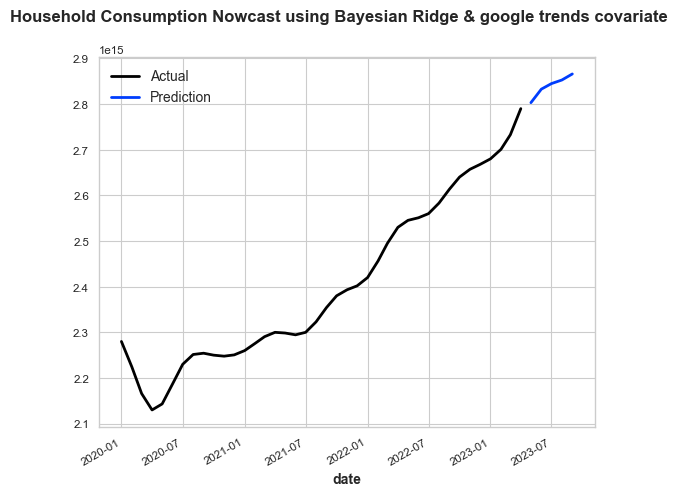

In [17]:
# Import pre-trained Bayesian Ridge model with google trend covariate from a pickle file
household_consumption_bayesian_google_trends = pickle.load(open(model_path + r'household_consumption_bayesian_google_trends.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_google_trends_bayesian = pred_ml_model(
                                model = household_consumption_bayesian_google_trends, 
                                len = google_trends_diff_len, 
                                train = household_consumption_ts, 
                                cov = google_trends_ts)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_google_trends_bayesian, 'Household Consumption Nowcast using Bayesian Ridge & google trends covariate')

In [18]:
# Create a DataFrame output using Bayesian Ridge model and google trends covariate with metric score evaluation
nowcast_google_trends_bayesian = out_pred_ml_df(
                                        model  =household_consumption_bayesian_google_trends,
                                        len = google_trends_diff_len, 
                                        train = household_consumption_ts, 
                                        cov = google_trends_ts,
                                        type_name = 'Google Trends',
                                        model_name = 'Bayesian Ridge',
                                        start_val=0.6
)

# Show nowcast_google_trends_bayesian DataFrame
nowcast_google_trends_bayesian

  0%|          | 0/17 [00:00<?, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Google Trends,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Google Trends,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Google Trends,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Google Trends,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Google Trends,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Google Trends,Bayesian Ridge,2.803017e+15,0.05,1.297246e+14,1.185045e+14,7.4,0.1948,0.0301
58,2023-06-01,Google Trends,Bayesian Ridge,2.832635e+15,0.05,1.297246e+14,1.185045e+14,7.4,0.1979,0.0106
59,2023-07-01,Google Trends,Bayesian Ridge,2.844797e+15,0.05,1.297246e+14,1.185045e+14,7.4,0.1647,0.0043
60,2023-08-01,Google Trends,Bayesian Ridge,2.852652e+15,0.05,1.297246e+14,1.185045e+14,7.4,0.1814,0.0028


#### Household Consumption Nowcast using electronic transaction nominal & Bayesian Ridge model

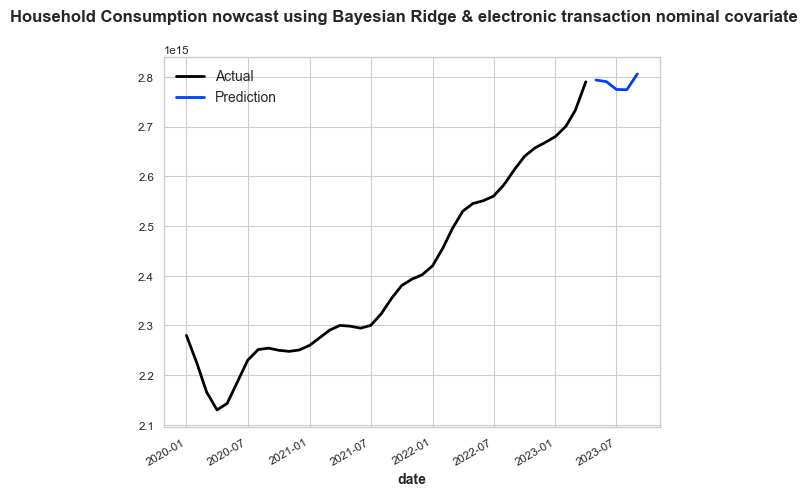

In [19]:
# Import pre-trained Bayesian Ridge model with electronic transaction nominal covariate from a pickle file
household_consumption_bayesian_electronic_transaction_nom = pickle.load(open(model_path + r'household_consumption_bayesian_electronic_transaction_nom.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_electronic_transaction_nom_bayesian = pred_ml_model(
                                            model = household_consumption_bayesian_electronic_transaction_nom, 
                                            len = electronic_transaction_nom_diff_len, 
                                            train = household_consumption_ts, 
                                            cov = electronic_transaction_nom_ts)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_electronic_transaction_nom_bayesian, 'Household Consumption nowcast using Bayesian Ridge & electronic transaction nominal covariate')

In [20]:
# Create a DataFrame output using Bayesian Ridge model and electronic transaction nominal covariate with metric score evaluation
nowcast_electronic_transaction_nom_bayesian = out_pred_ml_df(
                                                model = household_consumption_bayesian_electronic_transaction_nom,
                                                len = electronic_transaction_nom_diff_len, 
                                                train = household_consumption_ts, 
                                                cov = electronic_transaction_nom_ts,
                                                type_name = 'Electronic Transaction Nom',
                                                model_name = 'Bayesian Ridge',
                                                start_val=0.6
)

# Show nowcast_electronic_transaction_nom_bayesian DataFrame
nowcast_electronic_transaction_nom_bayesian

  0%|          | 0/17 [00:00<?, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Electronic Transaction Nom,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Electronic Transaction Nom,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Electronic Transaction Nom,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Electronic Transaction Nom,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Electronic Transaction Nom,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Electronic Transaction Nom,Bayesian Ridge,2.793605e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1312,-0.0191
58,2023-06-01,Electronic Transaction Nom,Bayesian Ridge,2.790359e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1219,-0.0012
59,2023-07-01,Electronic Transaction Nom,Bayesian Ridge,2.774566e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1479,-0.0057
60,2023-08-01,Electronic Transaction Nom,Bayesian Ridge,2.774084e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1098,-0.0002


#### Household Consumption Nowcast using Combined Covariates & Bayesian Ridge model

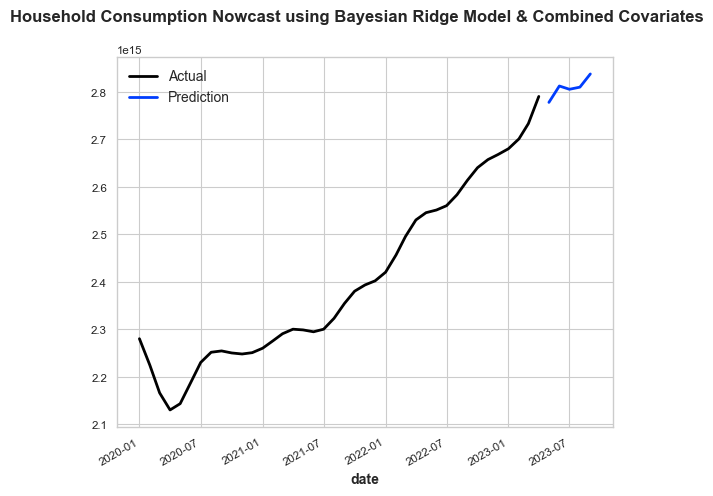

In [21]:
# Import pre-trained Bayesian Ridge model with combined covariate from a pickle file
household_consumption_bayesian_combined = pickle.load(open(model_path + r'household_consumption_bayesian_combined.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_combined_bayesian = pred_ml_model(
                            model = household_consumption_bayesian_combined, 
                            len = combined_diff_len, 
                            train = household_consumption_ts, 
                            cov = combined)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_combined_bayesian, 'Household Consumption Nowcast using Bayesian Ridge Model & Combined Covariates')

In [22]:
# Create a DataFrame output using Bayesian Ridge model and combined covariate with metric score evaluation
nowcast_combined_bayesian = out_pred_ml_df(
                                model = household_consumption_bayesian_electronic_transaction_nom,
                                len = electronic_transaction_nom_diff_len, 
                                train = household_consumption_ts, 
                                cov = electronic_transaction_nom_ts,
                                type_name = 'Combined',
                                model_name = 'Bayesian Ridge',
                                start_val=0.6
)

# Show nowcast_combined_bayesian DataFrame
nowcast_combined_bayesian

  0%|          | 0/17 [00:00<?, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Combined,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Combined,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Combined,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Combined,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Combined,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Combined,Bayesian Ridge,2.793605e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1312,-0.0191
58,2023-06-01,Combined,Bayesian Ridge,2.790359e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1219,-0.0012
59,2023-07-01,Combined,Bayesian Ridge,2.774566e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1479,-0.0057
60,2023-08-01,Combined,Bayesian Ridge,2.774084e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1098,-0.0002


#### Merge Bayesian Ridge nowcast into a single dataframe

In [23]:
# Create list for all the Bayesian Ridge nowcast DataFrame
bayesian_df = [nowcast_google_trends_bayesian, nowcast_electronic_transaction_nom_bayesian, nowcast_combined_bayesian]

# Merge all the Bayesian Ridge nowcast DataFrame into one DataFrame
bayesian_merge = pd.concat(bayesian_df)

# Show bayesian_merge DataFrame
bayesian_merge

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Google Trends,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Google Trends,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Google Trends,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Google Trends,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Google Trends,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Combined,Bayesian Ridge,2.793605e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1312,-0.0191
58,2023-06-01,Combined,Bayesian Ridge,2.790359e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1219,-0.0012
59,2023-07-01,Combined,Bayesian Ridge,2.774566e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1479,-0.0057
60,2023-08-01,Combined,Bayesian Ridge,2.774084e+15,0.03,8.614560e+13,8.163555e+13,5.0,0.1098,-0.0002


### LSTM (Long short-term memory)

#### Household consumption nowcast using google trends & LSTM model 

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

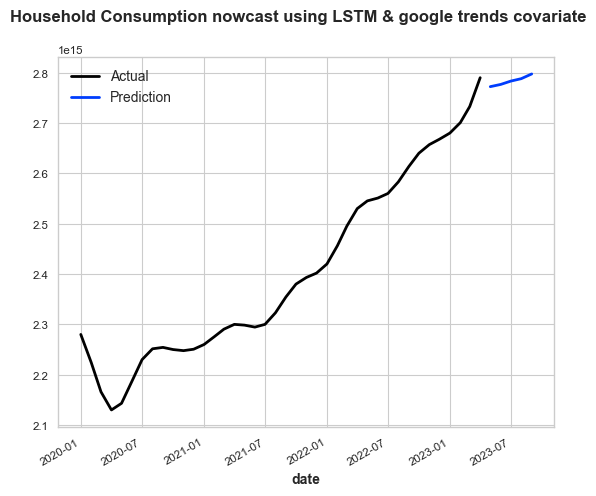

In [24]:
# Import pre-trained LSTM model with google trend covariate from a pickle file
household_consumption_lstm_google_trends = pickle.load(open(model_path + r'household_consumption_lstm_google_trends.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_google_trends_lstm = pred_ml_model(
                                model = household_consumption_lstm_google_trends, 
                                len = google_trends_diff_len, 
                                train = household_consumption_ts, 
                                cov = google_trends_ts)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_google_trends_lstm, 'Household Consumption nowcast using LSTM & google trends covariate')

In [25]:
# Create a DataFrame output using LSTM model and google trends covariate with metric score evaluation
nowcast_google_trends_lstm = out_pred_ml_df(
                                        model = household_consumption_lstm_google_trends,
                                        len = google_trends_diff_len, 
                                        train = household_consumption_ts, 
                                        cov = google_trends_ts,
                                        type_name = 'Google Trends',
                                        model_name = 'LSTM',
                                        start_val=0.6
)

# Show nowcast_google_trends_lstm DataFrame
nowcast_google_trends_lstm

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Google Trends,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Google Trends,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Google Trends,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Google Trends,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Google Trends,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Google Trends,LSTM,2.812653e+15,0.11,2.764724e+14,2.675725e+14,16.3,0.2211,0.1771
58,2023-06-01,Google Trends,LSTM,2.811229e+15,0.11,2.764724e+14,2.675725e+14,16.3,0.2199,-0.0005
59,2023-07-01,Google Trends,LSTM,2.805782e+15,0.11,2.764724e+14,2.675725e+14,16.3,0.2167,-0.0019
60,2023-08-01,Google Trends,LSTM,2.810204e+15,0.11,2.764724e+14,2.675725e+14,16.3,0.2150,0.0016


#### Household Consumption Nowcast using electronic transaction nominal & LSTM model

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

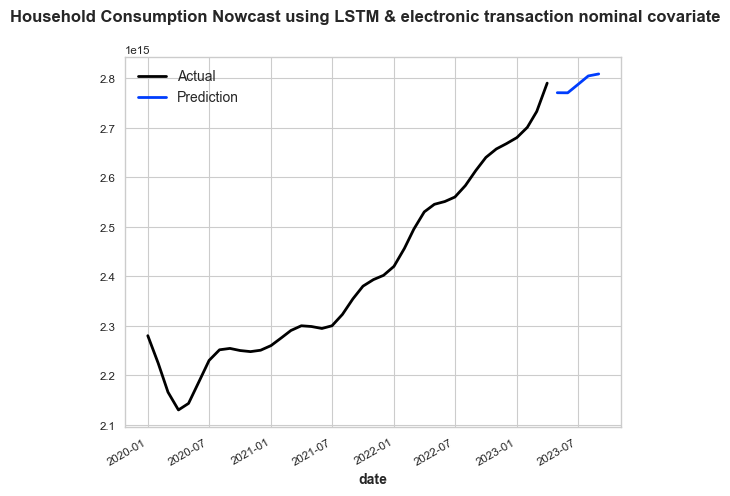

In [26]:
# Import pre-trained LSTM model with electronic transaction nominal covariate from a pickle file
household_consumption_lstm_electronic_transaction_nom = pickle.load(open(model_path + r'household_consumption_lstm_electronic_transaction_nom.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_electronic_transaction_nom_lstm = pred_ml_model(
                                            model = household_consumption_lstm_electronic_transaction_nom, 
                                            len = electronic_transaction_nom_diff_len, 
                                            train = household_consumption_ts, 
                                            cov = electronic_transaction_nom_ts)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_electronic_transaction_nom_lstm, 'Household Consumption Nowcast using LSTM & electronic transaction nominal covariate')


In [28]:
# Create a DataFrame output using LSTM model and electronic transaction nominal covariate with metric score evaluation
nowcast_electronic_transaction_nom_lstm = out_pred_ml_df(
                                                model = household_consumption_lstm_electronic_transaction_nom,
                                                len = electronic_transaction_nom_diff_len, 
                                                train = household_consumption_ts, 
                                                cov = electronic_transaction_nom_ts,
                                                type_name = 'Electronic Transaction Nom',
                                                model_name = 'LSTM',
                                                start_val=0.6
)

# Show nowcast_electronic_transaction_nom_lstm DataFrame
nowcast_electronic_transaction_nom_lstm

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Electronic Transaction Nom,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Electronic Transaction Nom,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Electronic Transaction Nom,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Electronic Transaction Nom,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Electronic Transaction Nom,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Electronic Transaction Nom,LSTM,2.797884e+15,0.11,2.762555e+14,2.673694e+14,16.3,0.2146,0.1707
58,2023-06-01,Electronic Transaction Nom,LSTM,2.776571e+15,0.11,2.762555e+14,2.673694e+14,16.3,0.2048,-0.0076
59,2023-07-01,Electronic Transaction Nom,LSTM,2.747296e+15,0.11,2.762555e+14,2.673694e+14,16.3,0.1913,-0.0105
60,2023-08-01,Electronic Transaction Nom,LSTM,2.747714e+15,0.11,2.762555e+14,2.673694e+14,16.3,0.1874,0.0002


#### Household Consumption Nowcast using combined covariates & LSTM model

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

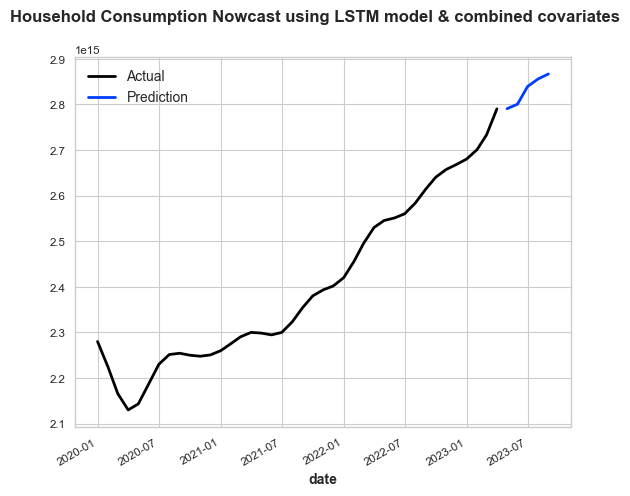

In [29]:
# Import pre-trained LSTM model with combined covariate from a pickle file
household_consumption_lstm_combined = pickle.load(open(model_path + r'household_consumption_lstm_combined.pkl', 'rb'))

# Nowcast household_consumption using that model
pred_combined_lstm = pred_ml_model(
                            model = household_consumption_lstm_combined, 
                            len = combined_diff_len, 
                            train = household_consumption_ts, 
                            cov = combined)

# Plot the nowcast result
plot_actual_pred(household_consumption_ts, pred_combined_lstm, 'Household Consumption Nowcast using LSTM model & combined covariates')

In [30]:
# Create a DataFrame output using LSTM model and combined covariate with metric score evaluation
nowcast_combined_lstm = out_pred_ml_df(
                                model = household_consumption_lstm_combined,
                                len = combined_diff_len, 
                                train = household_consumption_ts, 
                                cov = combined,
                                type_name = 'Combined',
                                model_name = 'LSTM',
                                start_val=0.6
)

# Show nowcast_combined_lstm DataFrame
nowcast_combined_lstm

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Combined,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Combined,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Combined,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Combined,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Combined,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Combined,LSTM,2.793461e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2167,0.1717
58,2023-06-01,Combined,LSTM,2.794524e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2228,0.0004
59,2023-07-01,Combined,LSTM,2.788723e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2120,-0.0021
60,2023-08-01,Combined,LSTM,2.798550e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2114,0.0035


In [31]:
 # Instantiate production LSTM model for training with google_trends data as future covariates
from darts.models import RNNModel
from darts.metrics import mape, rmse, mae
import numpy as np
scaler = Scaler()

lstm_test = RNNModel(
                        model="LSTM",
                        hidden_dim=30,
                        dropout=0.2,
                        batch_size=16,
                        n_epochs=300,
                        optimizer_kwargs={"lr": 1e-3},
                        random_state=42,
                        training_length=google_trends_diff_len*2,
                        input_chunk_length=google_trends_diff_len,
                        force_reset=True,
                        save_checkpoints=True)

In [32]:
scaled_train, scaled_cov = scaler.fit_transform([household_consumption_ts, combined])

pred_backtest_scaled = lstm_test.historical_forecasts(scaled_train,
                                               future_covariates=scaled_cov,
                                               start=0.8,
                                               forecast_horizon=1,
                                               verbose=True)

pred_backtest = scaler.inverse_transform(pred_backtest_scaled)

mape_val = mape(pred_backtest, household_consumption_ts)

mape_val
# = round(lstm_test.backtest(household_consumption_ts, start=0.8, future_covariates=combined, forecast_horizon=1, metric=mape, reduction=np.mean),2)

                                 



  0%|          | 0/9 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

0.7862273315479396

#### Merge LSTM nowcast into a single dataframe

In [33]:
# Create list for all the LSTM nowcast DataFrame
lstm_merge = [nowcast_google_trends_lstm, nowcast_electronic_transaction_nom_lstm, nowcast_combined_lstm]

# Merge all the LSTM nowcast DataFrame into one DataFrame
lstm_merge = pd.concat(lstm_merge)

# Show bayesian_merge DataFrame
lstm_merge

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Google Trends,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Google Trends,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Google Trends,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Google Trends,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Google Trends,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Combined,LSTM,2.793461e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2167,0.1717
58,2023-06-01,Combined,LSTM,2.794524e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2228,0.0004
59,2023-07-01,Combined,LSTM,2.788723e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2120,-0.0021
60,2023-08-01,Combined,LSTM,2.798550e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2114,0.0035


### Combined all model's nowcast DataFrames

In [34]:
# Create list for all the nowcast DataFrame
nowcast_df = [prophet_merge, bayesian_merge, lstm_merge]

# Merge all the nowcast DataFrame into one DataFrame
nowcast_merge = pd.concat(nowcast_df)

# Show nowcast_merge DataFrame
nowcast_merge

component,date,type,model,household_consumption,mape,rmse,mae,model_score,yoy_growth,mom_growth
0,2020-01-01,Google Trends,Actual,2.280000e+15,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-01,Google Trends,Actual,2.224206e+15,NaN,NaN,NaN,NaN,NaN,-0.0245
2,2020-03-01,Google Trends,Actual,2.165930e+15,NaN,NaN,NaN,NaN,NaN,-0.0262
3,2020-04-01,Google Trends,Actual,2.130000e+15,NaN,NaN,NaN,NaN,NaN,-0.0166
4,2020-05-01,Google Trends,Actual,2.143209e+15,NaN,NaN,NaN,NaN,NaN,0.0062
...,...,...,...,...,...,...,...,...,...,...
57,2023-05-01,Combined,LSTM,2.793461e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2167,0.1717
58,2023-06-01,Combined,LSTM,2.794524e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2228,0.0004
59,2023-07-01,Combined,LSTM,2.788723e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2120,-0.0021
60,2023-08-01,Combined,LSTM,2.798550e+15,0.12,2.808986e+14,2.721295e+14,16.6,0.2114,0.0035


## Create Covariate's Pearson Correlation Test DataFrames

In [35]:
# Combine prophet_merge DataFrame with household_consumption_breakdown DataFrame
prophet_test = pd.merge(prophet_merge, household_consumption_breakdown, how='left', left_on='date', right_on='date')

# Drop unnecessary columns
prophet_test = prophet_test.drop(['mape', 'rmse', 'mae','model_score', 'yoy_growth', 'mom_growth'], axis=1)

# Create Pearson test result for each covariates
prophet_breakdown = pearson_corr_rows(df=prophet_test, 
                                      target='household_consumption', 
                                      features=prophet_test.columns[4:], 
                                      included_col=['date','type','model'])

# Show nowcast_breakdown DataFrame
prophet_breakdown

,date,type,model,covariates,correlation_coefficient
0,2020-01-01,Google Trends,Actual,microcars & city cars,0.77
1,2020-02-01,Google Trends,Actual,microcars & city cars,0.77
2,2020-03-01,Google Trends,Actual,microcars & city cars,0.77
3,2020-04-01,Google Trends,Actual,microcars & city cars,0.77
4,2020-05-01,Google Trends,Actual,microcars & city cars,0.77
...,...,...,...,...,...
4273,2023-05-01,Combined,Prophet,credit nominal,0.84
4274,2023-06-01,Combined,Prophet,credit nominal,0.84
4275,2023-07-01,Combined,Prophet,credit nominal,0.84
4276,2023-08-01,Combined,Prophet,credit nominal,0.84


In [36]:
# Combine bayesian_merge DataFrame with household_consumption_breakdown DataFrame
bayesian_test = pd.merge(bayesian_merge, household_consumption_breakdown, how='left', left_on='date', right_on='date')

# Drop unnecessary columns
bayesian_test = bayesian_test.drop(['mape', 'rmse', 'mae','model_score', 'yoy_growth', 'mom_growth'], axis=1)

# Create Pearson test result for each covariates
bayesian_breakdown = pearson_corr_rows(df=bayesian_test, 
                                      target='household_consumption', 
                                      features=bayesian_test.columns[4:], 
                                      included_col=['date','type','model'])

# Show nowcast_breakdown DataFrame
bayesian_breakdown

,date,type,model,covariates,correlation_coefficient
0,2020-01-01,Google Trends,Actual,microcars & city cars,0.80
1,2020-02-01,Google Trends,Actual,microcars & city cars,0.80
2,2020-03-01,Google Trends,Actual,microcars & city cars,0.80
3,2020-04-01,Google Trends,Actual,microcars & city cars,0.80
4,2020-05-01,Google Trends,Actual,microcars & city cars,0.80
...,...,...,...,...,...
4273,2023-05-01,Combined,Bayesian Ridge,credit nominal,0.88
4274,2023-06-01,Combined,Bayesian Ridge,credit nominal,0.88
4275,2023-07-01,Combined,Bayesian Ridge,credit nominal,0.88
4276,2023-08-01,Combined,Bayesian Ridge,credit nominal,0.88


In [37]:
# Combine lstm_merge DataFrame with household_consumption_breakdown DataFrame
lstm_test = pd.merge(lstm_merge, household_consumption_breakdown, how='left', left_on='date', right_on='date')

# Drop unnecessary columns
lstm_test = lstm_test.drop(['mape', 'rmse', 'mae','model_score', 'yoy_growth', 'mom_growth'], axis=1)

# Create Pearson test result for each covariates
lstm_breakdown = pearson_corr_rows(df=lstm_test, 
                                      target='household_consumption', 
                                      features=lstm_test.columns[4:], 
                                      included_col=['date','type','model'])

# Show nowcast_breakdown DataFrame
lstm_breakdown

,date,type,model,covariates,correlation_coefficient
0,2020-01-01,Google Trends,Actual,microcars & city cars,0.62
1,2020-02-01,Google Trends,Actual,microcars & city cars,0.62
2,2020-03-01,Google Trends,Actual,microcars & city cars,0.62
3,2020-04-01,Google Trends,Actual,microcars & city cars,0.62
4,2020-05-01,Google Trends,Actual,microcars & city cars,0.62
...,...,...,...,...,...
4273,2023-05-01,Combined,LSTM,credit nominal,0.72
4274,2023-06-01,Combined,LSTM,credit nominal,0.72
4275,2023-07-01,Combined,LSTM,credit nominal,0.72
4276,2023-08-01,Combined,LSTM,credit nominal,0.72


In [38]:
# Combine all the nowcast_breakdown DataFrame into one DataFrame
nowcast_breakdown_merge = pd.concat([prophet_breakdown, bayesian_breakdown, lstm_breakdown])

## Save the Forecast Result DataFrame

Save the dataframe using %store magic function so that it can be used in another notebook

In [39]:
%store nowcast_merge
%store nowcast_breakdown_merge

Stored 'nowcast_merge' (DataFrame)
Stored 'nowcast_breakdown_merge' (DataFrame)
